In [2]:
# Import du jeu de donnée
import pandas as pd
import numpy as np

# copy on write

df = pd.read_csv('fr.openfoodfacts.org.products.csv',sep = '\t',low_memory=False)
# On enlève les colonnes avec moins de 10% de valeurs présentes
df2_under_10 = df.dropna(thresh=0.2*df.shape[0], axis=1)
# On retire les doublons pour la catégorie code et on garde le premier
df2_under_10 = df2_under_10.drop_duplicates(subset='code', keep='first')
# Les pnns_groups_1 regroupe les différentes catégories de produits, cependant tout n'est pas orthographié de la même manière
df3_pnns = df2_under_10.copy()
# Nettoyage des valeurs de pnns_groups_1, enlever les - et mettre en majuscule, remplacer Unknown par NaN
df3_pnns['pnns_groups_1'] = df3_pnns['pnns_groups_1'].str.replace('-',' ').str.capitalize().replace('Unknown',np.nan)

Nous allons réaliser des box plots en fonction des data que nous avons et par catégorie pour voir si l'on peut prédire le jeu de donnée. A en juger par la matrice de missing no. Une bonne moitié d'entre eux sont présent malgré la présence des _100g. Peut être qu'une méthode de regression logistique pourrait fonctionner. On va réaliser quelques analyses complémentaires pour voir à l'oeil s'il y a quelques variations visuellement intéressantes.

In [3]:
# Se débarasser des valeurs que l'on utilisera pas pour notre analyse (J'ai déjà réalisé le boxplot avec df3_pnns avant, et certaines données ne servait à rien, j'ai donc décidé d'itérer les graphiques qui viendront après avec df4 et df5)
df4_drop = df3_pnns.drop(columns=['url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'countries',
       'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'image_url', 'image_small_url', 'nutrition-score-uk_100g'])

In [4]:
import numpy as np

df5_IQR = df4_drop.copy()

for category in df5_IQR['pnns_groups_1'].unique():
    category_data = df5_IQR[df5_IQR['pnns_groups_1'] == category]
    for col in df5_IQR.select_dtypes(include=['float64']).columns:
        Q1 = category_data[col].quantile(0.25)
        Q3 = category_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remplacement des valeurs aberrantes par NaN pour la catégorie et la colonne courantes
        df5_IQR.loc[(df5_IQR['pnns_groups_1'] == category) & 
                    ((df5_IQR[col] < lower_bound) | (df5_IQR[col] > upper_bound)), col] = np.nan

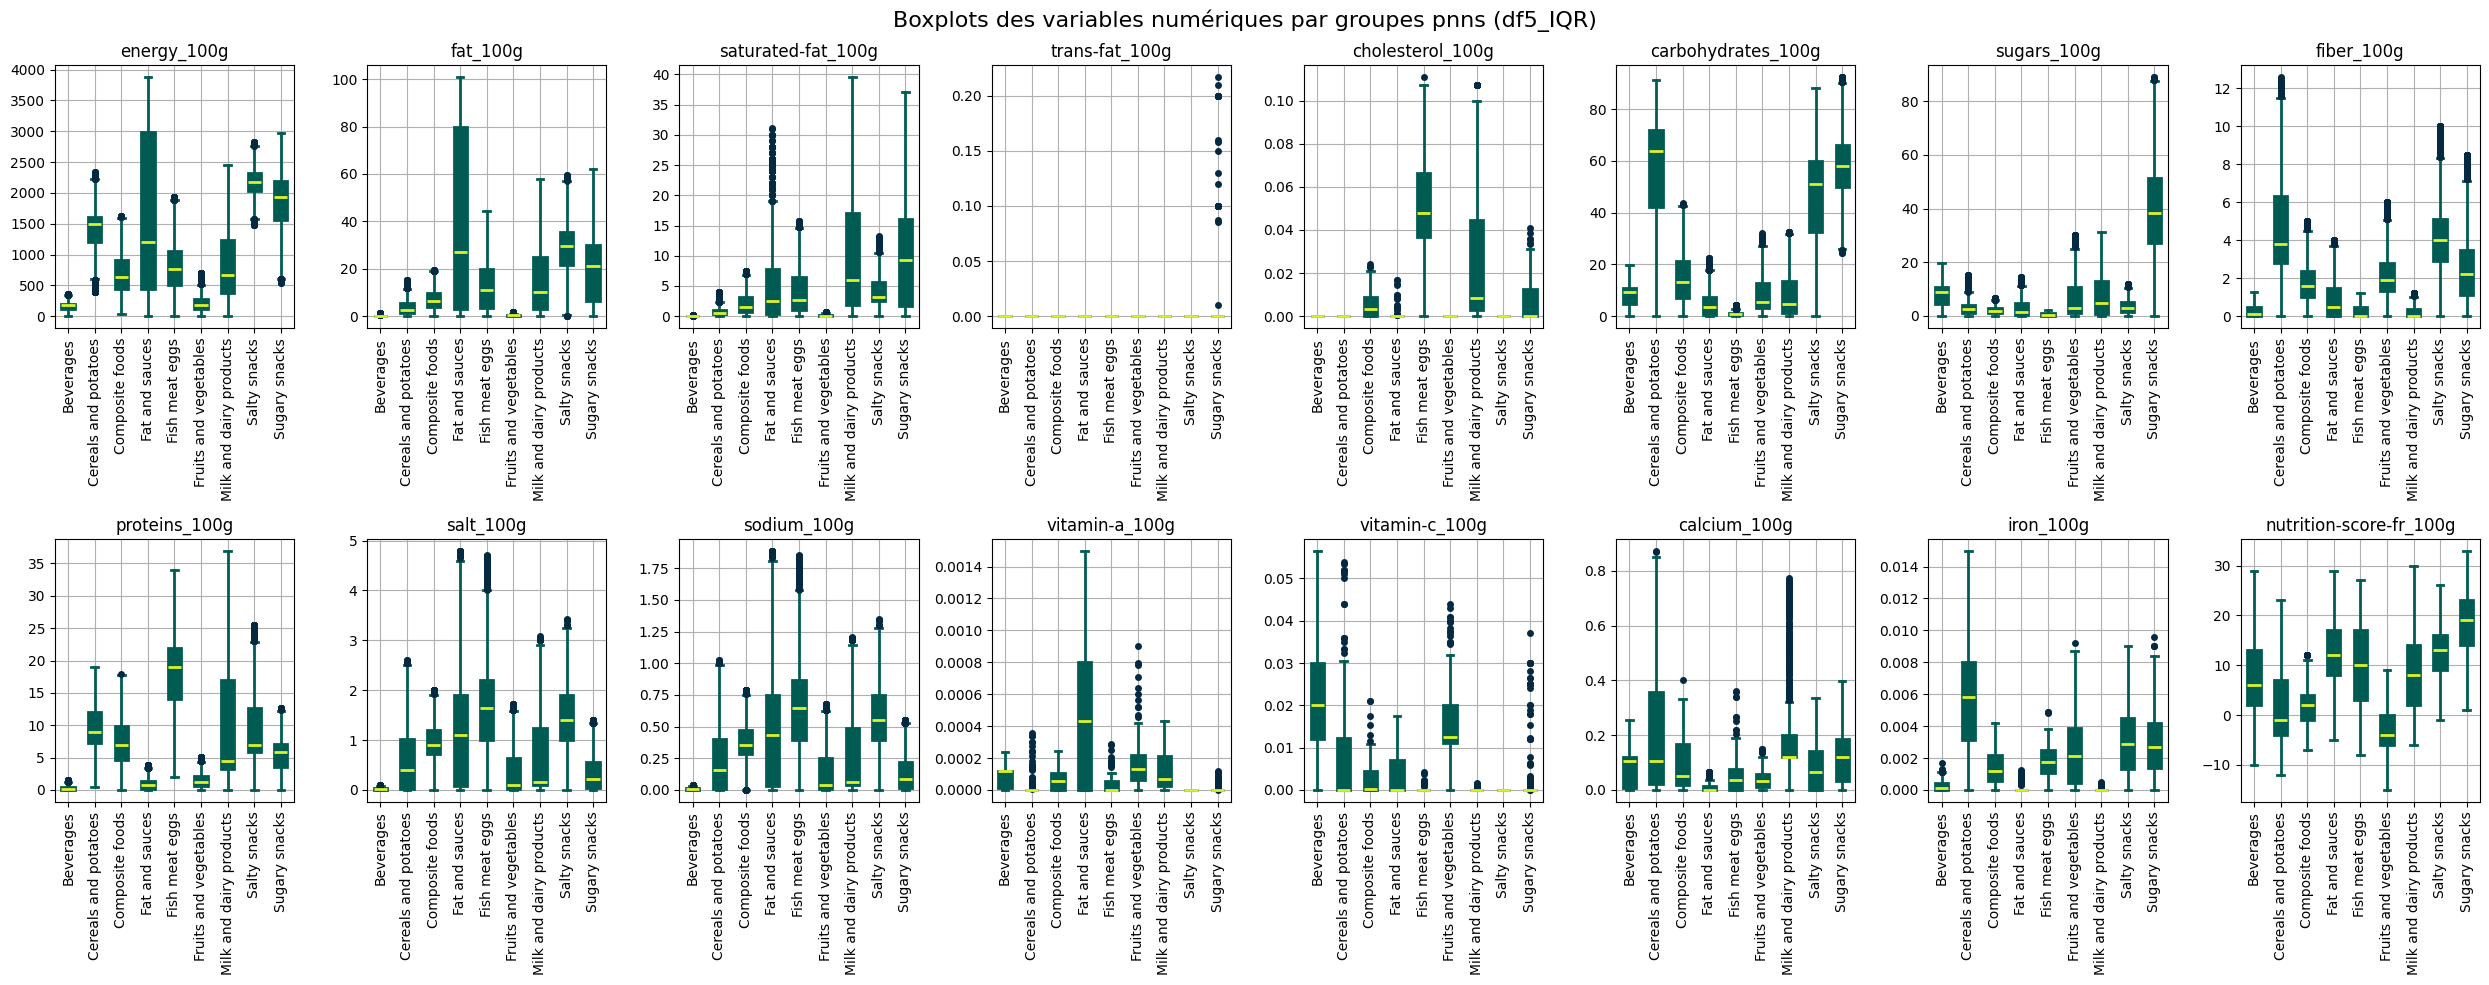

In [5]:
import matplotlib.pyplot as plt

def create_boxplots(df, df_name="DataFrame"):
    # Sélectionner les colonnes numériques
    num_cols = 8
    num_rows = int(np.ceil(len(df.select_dtypes(include=['float64']).columns) / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))
    axes = axes.flatten()

    # Créer les boxplots
    for i, col in enumerate(df.select_dtypes(include=['float64']).columns):
        df.boxplot(column=col, by='pnns_groups_1', ax=axes[i], patch_artist=True,
                   boxprops=dict(facecolor='#005C53', color='#005C53', linewidth=2),
                   medianprops=dict(color='#DBF227', linewidth=2),
                   whiskerprops=dict(color='#005C53', linewidth=2),
                   capprops=dict(color='#005C53', linewidth=2),
                   flierprops=dict(marker='o', markersize=5, markerfacecolor='#042940', markeredgewidth=0))
        axes[i].set_title(col)
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', labelrotation=90)

    for j in range(i + 1, num_cols * num_rows):
        fig.delaxes(axes[j])

    plt.suptitle(f'Boxplots des variables numériques par groupes pnns ({df_name})', fontsize=16)
    plt.tight_layout()
    plt.show()

create_boxplots(df5_IQR, "df5_IQR")

Les outliers ont été efficacement réduits en utilisant l'IQR par groupe PNNS, c'est plus propre pour réaliser une analyse.
Les groupes de energy_100g, fat_100g, et sugars_100g varient significativement entre les catégories, ce qui permet d'observer des différences claires entre les groupes.

In [10]:
# Anova sur les données bruts df5_IQR (pnns groups 1)

# Réalisation d'un test de levene pour vérifier l'égalité des variances
from scipy.stats import levene
from scipy.stats  import f_oneway
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Sélection des colonnes numériques
X5 = df5_IQR.select_dtypes(include=['float64']).copy()
X5 = X5.dropna()
X5_scaled = scaler.fit_transform(X5)


# Réalisation du test de Levene


ValueError: Must enter at least two input sample vectors.

In [11]:
X5.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000
mean,1213.413850,13.388307,4.712595,0.068531,0.018403,35.532153,15.388648,2.856313,7.960741,1.406179,0.553613,0.000131,0.006077,0.093859,0.002409,9.397871
std,746.871811,15.482913,6.843089,1.561611,0.322713,28.176595,19.523367,4.404628,8.186271,13.989093,5.507513,0.000552,0.106699,0.837774,0.149690,9.038551
min,0.000000,0.000000,0.000000,-3.570000,0.000000,0.000000,-17.860000,0.000000,-3.570000,0.000000,0.000000,0.000000,-0.002100,0.000000,-0.000260,-10.000000
25%,494.000000,0.820000,0.000000,0.000000,0.000000,9.090000,1.670000,0.000000,2.350000,0.142240,0.056000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1272.000000,7.780000,1.790000,0.000000,0.000000,28.570000,5.880000,1.500000,5.630000,0.741680,0.292000,0.000000,0.000000,0.035000,0.000960,10.000000
75%,1761.000000,21.430000,7.140000,0.000000,0.019000,60.710000,24.290000,3.600000,10.830000,1.450340,0.571000,0.000100,0.002100,0.100000,0.002400,17.000000
max,14644.000000,100.000000,100.000000,369.000000,95.238000,100.000000,100.000000,100.000000,100.000000,3048.000000,1200.000000,0.051818,35.714300,285.714000,50.000000,40.000000


In [15]:
# test de shapiro-wilk pour vérifier la normalité des données
from scipy.stats import shapiro

# Réalisation du test de Shapiro-Wilk
shapiro_results = df5_IQR.apply(shapiro)
shapiro_results


C:\Users\Richard\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 125983.
  res = hypotest_fun_out(*samples, **kwds)


,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,9.581682e-01,8.228169e-01,7.136361e-01,1.797592e-02,9.360084e-03,9.114309e-01,7.784096e-01,6.421732e-01,8.321865e-01,2.603494e-02,2.603486e-02,1.991334e-01,1.596140e-02,2.851318e-02,1.185961e-03,9.654713e-01
1,4.368781e-94,6.210324e-134,9.118589e-149,1.858859e-190,9.019039e-191,6.670192e-114,9.577052e-141,6.431167e-156,2.642835e-132,3.675357e-190,3.675330e-190,3.366424e-183,1.568865e-190,4.537163e-190,4.565125e-191,2.509753e-89


In [16]:
# Réalisation du test de shapiro sur des données sans nan
shapiro_results = X5.apply(shapiro)
shapiro_results

C:\Users\Richard\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 125983.
  res = hypotest_fun_out(*samples, **kwds)


,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,9.581682e-01,8.228169e-01,7.136361e-01,1.797592e-02,9.360084e-03,9.114309e-01,7.784096e-01,6.421732e-01,8.321865e-01,2.603494e-02,2.603486e-02,1.991334e-01,1.596140e-02,2.851318e-02,1.185961e-03,9.654713e-01
1,4.368781e-94,6.210324e-134,9.118589e-149,1.858859e-190,9.019039e-191,6.670192e-114,9.577052e-141,6.431167e-156,2.642835e-132,3.675357e-190,3.675330e-190,3.366424e-183,1.568865e-190,4.537163e-190,4.565125e-191,2.509753e-89


In [17]:
# test de krusta-wallis pour vérifier la normalité des données
from scipy.stats import kruskal

# Réalisation du test de Kruskal-Wallis
kruskal_results = kruskal(*[X5[col] for col in X5.columns])
print(f"Statistique de test de Kruskal-Wallis : {kruskal_results.statistic}")
print(f"p-value : {kruskal_results.pvalue}")

Statistique de test de Kruskal-Wallis : 1130161.1691138155
p-value : 0.0


In [ ]:
# Anova sur les données filtrées df6_IQR

In [9]:
# Anova One Way
from scipy import stats
f_statistic, p_values = stats.f_oneway(*[X5[col] for col in X5.columns])
print(f"Statistique de test de Fisher : {f_statistic}")

# Affichage des p-values
p_values = pd.Series(p_values, index=X5.columns)
print(p_values)

# Compte rendu de l'ANOVA
alpha = 0.05
print(f"Variables avec p-value < {alpha} :")
print(p_values[p_values < alpha])

Statistique de test de Fisher : 328424.53875791776
energy_100g                0.0
fat_100g                   0.0
saturated-fat_100g         0.0
trans-fat_100g             0.0
cholesterol_100g           0.0
carbohydrates_100g         0.0
sugars_100g                0.0
fiber_100g                 0.0
proteins_100g              0.0
salt_100g                  0.0
sodium_100g                0.0
vitamin-a_100g             0.0
vitamin-c_100g             0.0
calcium_100g               0.0
iron_100g                  0.0
nutrition-score-fr_100g    0.0
dtype: float64
Variables avec p-value < 0.05 :
energy_100g                0.0
fat_100g                   0.0
saturated-fat_100g         0.0
trans-fat_100g             0.0
cholesterol_100g           0.0
carbohydrates_100g         0.0
sugars_100g                0.0
fiber_100g                 0.0
proteins_100g              0.0
salt_100g                  0.0
sodium_100g                0.0
vitamin-a_100g             0.0
vitamin-c_100g             0.0
cal

L'anova normalement se fait sur des valeurs normales, je me suis peut être trompé dans mon analyse, j'ai décidé de ne pas l'ajouter à la présentation.


In [17]:
from scipy.stats import levene, shapiro, kruskal, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Sélection des colonnes numériques (sans standardisation)
X5 = df5_IQR.select_dtypes(include=['float64']).copy()
X5 = X5.dropna()

# Test de Levene (homogénéité des variances)
levene_results = {}
for col in X5.columns:
    groups = [X5.loc[df5_IQR['pnns_groups_1'] == group, col] for group in df5_IQR['pnns_groups_1'].unique() if not group is np.nan]
    levene_results[col] = levene(*groups)

# Test de Shapiro-Wilk (normalité)
shapiro_results = {}
for col in X5.columns:
    groups = [X5.loc[df5_IQR['pnns_groups_1'] == group, col] for group in df5_IQR['pnns_groups_1'].unique() if not group is np.nan]
    shapiro_results[col] = {group: shapiro(data) for group, data in zip(df5_IQR['pnns_groups_1'].unique(), groups)}

# Test de Kruskal-Wallis (alternative non paramétrique à l'ANOVA)
kruskal_results = {}
for col in X5.columns:
    groups = [X5.loc[df5_IQR['pnns_groups_1'] == group, col] for group in df5_IQR['pnns_groups_1'].unique() if not group is np.nan]
    kruskal_results[col] = kruskal(*groups)

# Affichage des résultats
print("Résultats du test de Levene :")
print(pd.DataFrame(levene_results))

print("\nRésultats du test de Shapiro-Wilk :")
print(pd.DataFrame(shapiro_results))

print("\nRésultats du test de Kruskal-Wallis :")
print(pd.DataFrame(kruskal_results))

# ANOVA (si approprié, après vérification des conditions)
anova_results = {}
for col in X5.columns:
    if levene_results[col].pvalue >= 0.05 and all(shapiro_results[col][group].pvalue >= 0.05 for group in shapiro_results[col]):
        groups = [X5[df5_IQR['pnns_groups_1'] == group][col] for group in df5_IQR['pnns_groups_1'].unique() if not group is np.nan]
        anova_results[col] = f_oneway(*groups)
        # Test post-hoc de Tukey si l'ANOVA est significative
        if anova_results[col].pvalue < 0.05:
            print(f"\nTest post-hoc de Tukey pour {col} :")
            print(pairwise_tukeyhsd(X5[col], df5_IQR['pnns_groups_1']))

print("\nRésultats de l'ANOVA (si applicable) :")
print(pd.DataFrame(anova_results))

C:\Users\Richard\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Richard\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Richard\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Richard\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Richard\AppData\Roaming\Python\Python31

Résultats du test de Levene :
    energy_100g      fat_100g  saturated-fat_100g  trans-fat_100g  \
0  6.163791e+00  9.834768e+00        1.670803e+01        1.208988   
1  1.749481e-07  1.962575e-12        3.160163e-21        0.292303   

   cholesterol_100g  carbohydrates_100g   sugars_100g    fiber_100g  \
0      1.759038e+01        8.297944e+00  2.735360e+01  1.806633e+01   
1      2.659510e-22        2.246845e-10  2.073714e-33  7.080996e-23   

   proteins_100g  salt_100g  sodium_100g  vitamin-a_100g  vitamin-c_100g  \
0   1.129840e+01   5.434142     5.421836    1.650276e+01    1.528184e+01   
1   2.291405e-14   0.000002     0.000002    5.643479e-21    1.833824e-19   

   calcium_100g     iron_100g  nutrition-score-fr_100g  
0  9.008936e+00  3.126363e+01                 4.738499  
1  2.487648e-11  1.730034e-37                 0.000015  

Résultats du test de Shapiro-Wilk :
                                                          energy_100g  \
NaN                         (0.9247550

Pour le test de Levene, presque toutes les variables ont des p-values très faibles, l'hypothèse d'homogénéité des variances est rejetée sauf pour la variable trans-fat_100g avec une p-value de 0,29 (non significative)

Test de Shapiro-Wilk (Normalité):
La plupart des groupes au sein chaque variable ont des faibles p-values, on est pas sur une distribution normale (contre indiqué pour réaliser une anova)

Pour les variables (saturated-fat_100g, trans-fat_100g, cholesterol_100g, vitamin-a_100g, vitamin-c_100g), la p-value à 1 est peut être due à mon netoyage de donnée... Je n'ai pas trop l'info

Test de Kruskal-Wallis (Différences entre groupes):
Conclusion des faibles p-values -> différences significatives entre les pnns_groups_1 pour toutes les variables

Anova :
Non appliqué comme les conditions d'homogénéité des variances et de normalité ne sont pas remplies pour la plupart des variables.

In [15]:
from scikit_posthocs import posthoc_dunn
dunn_results = {}
for col in X5.columns:
    groups = [X5.loc[df5_IQR['pnns_groups_1'] == group, col] for group in df5_IQR['pnns_groups_1'].unique() if not group is np.nan]
    dunn_results[col] = posthoc_dunn(groups, p_adjust='bonferroni')  # Correction de Bonferroni pour les comparaisons multiples
    
print("\nRésultats du test post-hoc de Dunn :")
for col, result in dunn_results.items():
    print(f"\n{col}:\n{result}")



Résultats du test post-hoc de Dunn :

energy_100g:
              1             2             3             4             5  \
1  1.000000e+00  1.929530e-17  1.138544e-05  1.000000e+00  3.952881e-01   
2  1.929530e-17  1.000000e+00  7.327391e-07  4.811086e-13  3.028944e-07   
3  1.138544e-05  7.327391e-07  1.000000e+00  1.038935e-02  1.000000e+00   
4  1.000000e+00  4.811086e-13  1.038935e-02  1.000000e+00  1.000000e+00   
5  3.952881e-01  3.028944e-07  1.000000e+00  1.000000e+00  1.000000e+00   
6  1.000000e+00  2.786344e-29  2.866875e-10  6.673163e-01  1.872907e-02   
7  3.356562e-01  4.346131e-15  6.456953e-02  1.000000e+00  1.000000e+00   
8  2.702169e-01  9.193632e-25  2.717545e-03  1.000000e+00  1.000000e+00   
9  1.451662e-12  1.000000e+00  3.007847e-03  7.527266e-09  5.362713e-05   

              6             7             8             9  
1  1.000000e+00  3.356562e-01  2.702169e-01  1.451662e-12  
2  2.786344e-29  4.346131e-15  9.193632e-25  1.000000e+00  
3  2.866875e-10  

Vue le grand nombre de ligne, j'ai laissé l'interprétation à gemini
Principales conclusions par nutriment :

* **energy_100g** (Énergie) :
Différences significatives entre presque toutes les catégories.
Les "Sugary snacks" et "Fish meat eggs" ont les valeurs d'énergie les plus élevées.
Les "Fruits and vegetables" ont les valeurs d'énergie les plus basses.

* **fat_100g** (Matières grasses) :
Différences significatives entre presque toutes les catégories.
Les "Fat and sauces" ont les valeurs de matières grasses les plus élevées.
Les "Fruits and vegetables", "Beverages", et "Sugary snacks" ont les valeurs les plus basses.
saturated-fat_100g (Acides gras saturés) :
Les "Fat and sauces" et "Milk and dairy products" ont des valeurs plus élevées.
Les autres catégories ont des valeurs similaires et relativement basses.

* **trans-fat_100g** (Acides gras trans) :
Aucune différence significative entre les groupes (probablement en raison d'un manque de données pour certaines catégories).

* **cholesterol_100g** (Cholestérol) :
Les "Fish meat eggs" ont les valeurs de cholestérol les plus élevées.
Les autres catégories ont des valeurs nulles ou proches de zéro.

* **carbohydrates_100g** (Glucides) :
Différences significatives entre presque toutes les catégories.
Les "Sugary snacks" et "Cereals and potatoes" ont les valeurs les plus élevées.
Les "Fish meat eggs" et "Fat and sauces" ont les valeurs les plus basses.

* **sugars_100g** (Sucres) :
Les "Sugary snacks" ont les valeurs de sucre les plus élevées, suivies par les "Beverages".
Les "Fruits and vegetables" et "Fish meat eggs" ont les valeurs les plus basses.

* **fiber_100g** (Fibres) :
Les "Cereals and potatoes" ont les valeurs de fibres les plus élevées.
Les "Fish meat eggs" et "Fat and sauces" ont les valeurs les plus basses.

* **proteins_100g** (Protéines) :
Les "Fish meat eggs" ont les valeurs de protéines les plus élevées.
Les "Fruits and vegetables" et "Sugary snacks" ont les valeurs les plus basses.

* **salt_100g** (Sel) et **sodium_100g** (Sodium) :
Différences significatives entre la plupart des catégories.
Les "Composite foods" et "Salty snacks" ont les valeurs les plus élevées.
Les "Fruits and vegetables" ont les valeurs les plus basses.

* **vitamin-a_100g** (Vitamine A) :
Les "Fish meat eggs" ont les valeurs de vitamine A les plus élevées.
La plupart des autres catégories ont des valeurs très faibles ou nulles.

* **vitamin-c_100g** (Vitamine C) :
Les "Fruits and vegetables" ont les valeurs de vitamine C les plus élevées.
La plupart des autres catégories ont des valeurs très faibles ou nulles.

* **calcium_100g** (Calcium) :
Les "Milk and dairy products" ont les valeurs de calcium les plus élevées.
Les autres catégories ont des valeurs nettement inférieures.

* **iron_100g** (Fer) :
Différences significatives entre la plupart des catégories.
Les "Composite foods" et "Cereals and potatoes" ont les valeurs les plus élevées.
Les "Fruits and vegetables" et "Sugary snacks" ont les valeurs les plus basses.
nutrition-score-fr_100g (Nutri-score) :
Les "Sugary snacks" ont le Nutri-score le plus élevé (moins bon).
Les "Fruits and vegetables" ont le Nutri-score le plus bas (meilleur).

In [18]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Créer une copie de df5_IQR pour l'ANOVA
df5_anova = df5_IQR.copy()

# Supprimer les lignes avec des valeurs manquantes dans df5_anova
df5_anova.dropna(inplace=True)

# Sélectionner les colonnes numériques (sans standardisation)
X5_anova = df5_anova.select_dtypes(include=['float64']).copy()

# ANOVA (après avoir vérifié les conditions de normalité et d'homogénéité des variances)
anova_results = {}
for col in X5_anova.columns:
    if levene_results[col].pvalue >= 0.05 and all(shapiro_results[col][group].pvalue >= 0.05 for group in shapiro_results[col]):
        groups = [X5_anova[df5_anova['pnns_groups_1'] == group][col] for group in df5_anova['pnns_groups_1'].unique()]
        anova_results[col] = f_oneway(*groups)
        # Test post-hoc de Tukey si l'ANOVA est significative
        if anova_results[col].pvalue < 0.05:
            print(f"\nTest post-hoc de Tukey pour {col} (ANOVA significative) :")
            print(pairwise_tukeyhsd(X5_anova[col], df5_anova['pnns_groups_1']))

print("\nRésultats de l'ANOVA (si applicable) :")
print(pd.DataFrame(anova_results))



Résultats de l'ANOVA (si applicable) :
Empty DataFrame
Columns: []
Index: []


In [19]:
# ANOVA (sans vérification des conditions, avec avertissement)
anova_results_forced = {}
for col in X5_anova.columns:
    groups = [X5_anova[df5_anova['pnns_groups_1'] == group][col] for group in df5_anova['pnns_groups_1'].unique()]
    anova_results_forced[col] = f_oneway(*groups)
    # Test post-hoc de Tukey si l'ANOVA est significative
    if anova_results_forced[col].pvalue < 0.05:
        print(f"\nTest post-hoc de Tukey pour {col} (ANOVA forcée significative - Attention : résultats à interpréter avec prudence car les conditions de validité de l'ANOVA ne sont pas remplies) :")
        print(pairwise_tukeyhsd(X5_anova[col], df5_anova['pnns_groups_1']))

print("\nRésultats de l'ANOVA forcée (à interpréter avec prudence) :")
print(pd.DataFrame(anova_results_forced))


Test post-hoc de Tukey pour energy_100g (ANOVA forcée significative - Attention : résultats à interpréter avec prudence car les conditions de validité de l'ANOVA ne sont pas remplies) :
                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
         group1                  group2          meandiff  p-adj    lower      upper   reject
---------------------------------------------------------------------------------------------
              Beverages    Cereals and potatoes  1220.8321    0.0   897.7247 1543.9395   True
              Beverages         Composite foods   316.3198 0.2567    -85.342  717.9816  False
              Beverages          Fat and sauces   639.7032    0.0   291.2701  988.1364   True
              Beverages          Fish meat eggs   540.8991 0.0023   121.1292  960.6691   True
              Beverages   Fruits and vegetables    52.2769    1.0  -374.7262    479.28  False
              Beverages Milk and dairy products   501.5903   